In [1]:
import numpy as np
from numpy import random
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import itertools
import os
import tensorflow as tf
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras.utils.np_utils import to_categorical
import pandas as pd
path='C:\\Users\dmckenzie\Desktop\K12RoomTypeClassData2.csv'
DATIS=pd.read_csv(path)
DATIS=DATIS.drop(columns='Unnamed: 0')
import re
def preprocessor(text): 
    text = re.sub(r'[^\w\s]','', text)
    text = text.lower()
    return text

DATIS['CleanName']=DATIS['RoomName'].str.replace('/',' ').replace({' +':' '},regex=True).apply(preprocessor)
DATIS['NameLen']=DATIS['RoomName'].str.len()
DATIS['RoomName']=DATIS['RoomName'].str.lower()
DATIS['TokenCount']=((DATIS['RoomName'].str.len()-DATIS['RoomName'].str.replace(' ','').str.len())+1)
DATIS.Label2=DATIS.Label2.str.lower()
DATIS['RoomType']=np.where(DATIS['RoomName'].str.lower().str.contains('corridor'),'corridor',
         np.where(DATIS['RoomName'].str.lower().str.contains('shower'),'shower',
         np.where(DATIS['RoomName'].str.contains('|'.join([' rr','restroom','bathroom','lavartory',
                                                        'washroom','wash room','wash_room',
                                                        'tlt','toielt','bath room','rest room',
                                                        'bath_room','rest_room'])),'bathroom',
           np.where(DATIS['Label2']=='small group','other',        
          np.where(DATIS['Label2']=='special english','other',DATIS['Label2'])))))

binomiallist=[]
for i in range(0,len(DATIS)):
        binomiallist.append(np.random.binomial(1, .025))

DATIS['Keep']=binomiallist
DATIS['Keep']=np.where(DATIS['RoomType']=='other',DATIS['Keep'],1)
DATIS2=DATIS[DATIS['Keep']==1]
DATIS2=DATIS2.drop_duplicates(['RoomType','CleanName'])
y = DATIS2.RoomType.str.lower()
DATIS2['Name'] = DATIS2['CleanName']
X = DATIS2['Name']
        

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, random_state = 42)

In [6]:
from sklearn.pipeline import Pipeline

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer


vec=TfidfVectorizer(max_df=.4,min_df=1,norm='l2',smooth_idf=True,use_idf=True,sublinear_tf=False)
vec.fit(X_train)   
#=vec.fit(X_train)
#X.toarray()
X=vec.transform(X_train)
X.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [32]:
grid_search.best_params_

{'tfidf__max_df': 0.4,
 'tfidf__min_df': 1,
 'tfidf__norm': 'l2',
 'tfidf__smooth_idf': True,
 'tfidf__sublinear_tf': False,
 'tfidf__use_idf': True}

In [33]:
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import TfidfVectorizer


tfidfvec=TfidfVectorizer(ngram_range=(1,3),max_df=.25,min_df=1,norm='l2',smooth_idf=True,sublinear_tf=False,use_idf=True)
mod=SGDClassifier(penalty='l1',loss='log',alpha=0.00001)

#vectorizer.fit(X_train)
#X_train2=vectorizer.transform(X_train)
#X_test2=vectorizer.transform(X_test)




text_clf = Pipeline([ 
    ('tfidf', tfidfvec),
    ('clf', mod),
])


text_clf.fit(X_train, y_train)

#mod.fit(X_train2, y_train)

from sklearn.metrics import classification_report
#y_pred = mod.predict(X_test2)
y_pred2 = text_clf.predict(X_test)
print('accuracy %s' % accuracy_score(y_pred2, y_test))
print(classification_report(y_test, y_pred2))


#print('accuracy %s' % accuracy_score(y_pred, y_test))
#print(classification_report(y_test, y_pred))

accuracy 0.9103641456582633
                   precision    recall  f1-score   support

             a.v.       0.83      0.53      0.65        19
        art exist       0.91      1.00      0.95        10
         bathroom       0.97      0.90      0.93        70
        classroom       0.94      0.96      0.95       125
 conference large       0.92      1.00      0.96        12
         corridor       0.88      1.00      0.93        14
        custodial       1.00      0.86      0.92         7
       electrical       0.86      1.00      0.92         6
              gym       0.90      1.00      0.95        18
 kitchen district       0.80      1.00      0.89         4
              lab       0.93      0.93      0.93        88
      library sto       0.86      1.00      0.92         6
       lobby vest       0.91      1.00      0.95        10
    locker shower       0.85      1.00      0.92        39
lounge leadership       1.00      1.00      1.00         8
       mechanical       0.9

In [34]:
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import StringTensorType
from onnxmltools import save_model
from onnxruntime import InferenceSession

In [35]:
onnx_model = convert_sklearn(text_clf,
name='RoomTypeClassifier',
initial_types=[('input', StringTensorType([1, 1]))]
)

save_model(onnx_model, 'RoomClass.onnx')
sess = InferenceSession("RoomClass.onnx")
label_name = sess.get_outputs()[0].name
input_name = sess.get_inputs()[0].name

#res = sess.run(None, input_feed={'input': np.array([['corridor']])})

C:\Users\dmckenzie\Anaconda3\envs\Three Seven\lib\site-packages\skl2onnx\operator_converters\text_vectoriser.py:185: UserWarning: Converter for TfidfVectorizer will use scikit-learn regular expression by default in version 1.6.
  UserWarning)
C:\Users\dmckenzie\Anaconda3\envs\Three Seven\lib\site-packages\skl2onnx\common\_container.py:595: UserWarning: Unable to find operator 'Tokenizer' in domain 'com.microsoft' in ONNX, op_version is forced to 1.
  op_type, domain))


NameError: name 'sess' is not defined

In [115]:
res

[array(['corridor'], dtype=object),
 [{'a.v.': 0.0005470490432344377,
   'art exist': 9.61030600592494e-05,
   'bathroom': 0.00018557437579147518,
   'classroom': 0.0002550547069404274,
   'conference large': 0.0008631146629340947,
   'corridor': 0.9907276630401611,
   'custodial': 0.0006747011211700737,
   'electrical': 0.00015836229431442916,
   'gym': 0.0010776950512081385,
   'kitchen district': 0.0007900006021372974,
   'lab': 0.0002391795424045995,
   'library sto': 0.00027800322277471423,
   'lobby vest': 0.0005601845914497972,
   'locker shower': 0.0007997159264050424,
   'lounge leadership': 0.0004221965791657567,
   'mechanical': 0.0003763679414987564,
   'music vocal': 9.92583081824705e-05,
   'office specialist': 0.0002946862077806145,
   'other': 3.795786824412062e-06,
   'principal vice': 0.00038096358184702694,
   'science': 2.462184420437552e-05,
   'shower': 0.000591575400903821,
   'storage': 0.0005541396676562726}]]

In [43]:
with open("TextClassifier1.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

In [42]:
res

[array(['services1'], dtype=object),
 [{'amenity': 0.07348394393920898,
   'circulation': 0.044751111418008804,
   'collaboration: closed': 0.07773763686418533,
   'collaboration: open': 0.04349435120820999,
   'desking: open workstation': 0.031024377793073654,
   'desking: private office': 0.049801651388406754,
   'lab': 0.04049787297844887,
   'services 2': 0.039142508059740067,
   'services1': 0.4987942576408386,
   'support': 0.10127229988574982}]]

In [336]:
import pickle

In [337]:
pickle.dump(vectorizer, open('C:\\Users\dmckenzie\documents\\roomvectorizer.pickle', "wb"))

In [338]:
pickle.dump(mod, open('C:\\Users\dmckenzie\documents\\roommodel.pickle', "wb"))

In [68]:
len(y_pred)
len(X_test)

4948

In [79]:
matchdf=pd.DataFrame({'A':list(y_pred2[X_test.isin(list(X_train))==False]),
              'B':list(y_test[X_test.isin(list(X_train))==False])})

In [80]:
matchdf['C']=(matchdf['A']==matchdf['B'])*1

In [81]:
matchdf['D']=1

In [82]:
labels=list(matchdf.groupby(['A'])['D'].sum().index)

In [83]:
scores=list(matchdf.groupby(['A'])['C'].sum().values/matchdf.groupby(['A'])['D'].sum().values)

In [84]:
print('Accuracy:',matchdf['C'].sum()/matchdf['D'].sum())

Accuracy: 0.8950617283950617


In [85]:
pd.DataFrame({'Category':labels,'Guesses':list(matchdf.groupby(['A'])['D'].sum().values),'True Positive Rate':scores})

,Category,Guesses,True Positive Rate
0,art digital exist,10,0.600000
1,bathroom,32,0.843750
2,classroom,83,0.879518
3,collaboration student work,4,1.000000
4,common social collaboration,11,0.636364
5,conference resource collaboration,6,0.833333
6,corridor mail central,3,0.666667
7,lab exist flex,23,0.782609
8,locker athletic official,13,1.000000
9,mechanical yard auditorium,5,0.800000


C:\Users\dmckenzie\Anaconda3\envs\Three Seven\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dmckenzie\Anaconda3\envs\Three Seven\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\dmckenzie\Anaconda3\envs\Three Seven\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py", line 728, in fit
    sample_weight=sample_weight)
  File "C:\Users\dmckenzie\Anaconda3\envs\Three Seven\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py", line 541, in _fit
    accept_large_sparse=False)
  File "C:\Users\dmckenzie\Anaconda3\envs\Three Seven\lib\site-packages\sklearn\base.py", line 432, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "C:\Users\dmckenzie\Anaconda3\e

C:\Users\dmckenzie\Anaconda3\envs\Three Seven\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dmckenzie\Anaconda3\envs\Three Seven\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\dmckenzie\Anaconda3\envs\Three Seven\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py", line 728, in fit
    sample_weight=sample_weight)
  File "C:\Users\dmckenzie\Anaconda3\envs\Three Seven\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py", line 541, in _fit
    accept_large_sparse=False)
  File "C:\Users\dmckenzie\Anaconda3\envs\Three Seven\lib\site-packages\sklearn\base.py", line 432, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "C:\Users\dmckenzie\Anaconda3\e

<AxesSubplot:title={'center':'Classifier Validation Score As Training Data Grows'}, xlabel='Training Data Size', ylabel='Validation Score'>

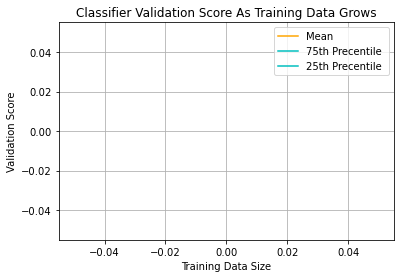

In [39]:
import numpy as np
from sklearn.model_selection import learning_curve
from sklearn.datasets import load_iris
from sklearn.linear_model import Ridge

#np.random.seed(0)
#X, y = load_iris(return_X_y=True)
#indices = np.arange(y.shape[0])
#np.random.shuffle(indices)
#X, y = X[indices], y[indices]

train_sizes, train_scores, valid_scores = learning_curve(SGDClassifier(penalty='l1',loss='log',alpha=0.00001),
                                                         X_train, y_train, train_sizes=[10,20,30,40,50,60,70,80,90,100,
                                                                                         110,120,130,140,150,160,170,180,190,200,
                                                                                         210,220,230,240,250,260,270,280,290,300,
                                                                                         310,320,330,340,350,360,370,380,390,400,
                                                                                        410,420,430],cv=5)
pd.DataFrame({'Mean':list(pd.DataFrame(valid_scores.transpose()).median()),
             '75th Precentile ':list(pd.DataFrame(valid_scores.transpose()).quantile(0.75)),
             '25th Precentile':list(pd.DataFrame(valid_scores.transpose()).quantile(0.25))},
             index=train_sizes).plot(color = ['orange', 'c','c'],
                                    xlabel='Training Data Size',ylabel='Validation Score',
                                     grid=True,title='Classifier Validation Score As Training Data Grows')

In [37]:
pd.DataFrame(valid_scores.transpose()).mean().plot()

NameError: name 'valid_scores' is not defined

In [38]:
pd.DataFrame(pd.DataFrame(valid_scores.transpose())).plot()

NameError: name 'valid_scores' is not defined